In [1]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import cudf
from cuml.ensemble import RandomForestClassifier as curfc
from cuml.metrics.accuracy import accuracy_score as cuacc
from cuml.metrics import roc_auc_score as cuauc
from cuml.neighbors import KNeighborsClassifier
from cuml.naive_bayes import GaussianNB
from cuml.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
loan = pd.read_csv('/datasets/loan_data/loan_p_class.csv')
print(loan.shape)
loan.head()

(3387379, 19)


,year,emp_length_int,home_ownership_cat,annual_inc,income_cat,loan_amount,term_cat,application_type_cat,purpose_cat,interest_payment_cat,loan_condition_cat,interest_rate,grade_cat,dti,total_pymnt,total_rec_prncp,recoveries,installment,region
0,4,10.0,1,24000,1,5000,1,1,1,1,0,10.65,2,27.65,5861.071414,5000.00,0.00,162.87,3
1,4,0.5,1,30000,1,2500,2,1,2,2,1,15.27,3,1.00,1008.710000,456.46,117.08,59.83,2
2,4,10.0,1,12252,1,2400,1,1,3,2,0,15.96,3,8.72,3003.653644,2400.00,0.00,84.33,1
3,4,10.0,1,49200,1,10000,1,1,4,2,0,13.49,3,20.00,12226.302210,10000.00,0.00,339.31,4
4,4,1.0,1,80000,1,3000,2,1,4,1,0,12.69,2,17.94,3242.170000,2233.10,0.00,67.79,4


## Classification
### Rscale and split data to training and testing sets 

In [3]:
X = loan.drop(['loan_condition_cat'], axis=1) 

cols = ['year', 'emp_length_int', 'home_ownership_cat', 'annual_inc','income_cat', 'loan_amount', 'term_cat',
        'application_type_cat', 'purpose_cat', 'interest_payment_cat', 'interest_rate', 'grade_cat', 'dti', 
        'total_pymnt', 'total_rec_prncp', 'recoveries', 'installment', 'region']

y = loan['loan_condition_cat']
y = pd.Series(y.astype(np.int32))


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = preprocessing.scale(X_train)
X_train = pd.DataFrame(X_train, columns = cols)
X_train = pd.DataFrame(X_train.astype(np.float32))

X_test = preprocessing.scale(X_test)
X_test = pd.DataFrame(X_test, columns = cols)
X_test = pd.DataFrame(X_test.astype(np.float32))

### Feature Selection

In [4]:
def processSubset(X_label, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    X_smf = ' + '.join(X_label)
    f     = 'loan_condition_cat ~ {}'.format(X_smf)
    # Fit model
    lin_reg = smf.ols(formula=f, data=pd.concat([X_train, y_train], axis=1)).fit()
    RSS = ((lin_reg.predict(X_test[list(X_label)]) - y_test) ** 2).sum() #on test set
    return {'model': lin_reg, 'RSS': RSS}

In [5]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [6]:
models_test = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):
    models_test.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    exog = models_test.loc[i]['model'].model.exog_names.copy()
    exog.remove('Intercept')
    predictors = exog
    print(i, predictors)

1 ['term_cat']
2 ['term_cat', 'year']
3 ['term_cat', 'year', 'region']
4 ['term_cat', 'year', 'region', 'emp_length_int']
5 ['term_cat', 'year', 'region', 'emp_length_int', 'installment']
6 ['term_cat', 'year', 'region', 'emp_length_int', 'installment', 'purpose_cat']
7 ['term_cat', 'year', 'region', 'emp_length_int', 'installment', 'purpose_cat', 'income_cat']
8 ['term_cat', 'year', 'region', 'emp_length_int', 'installment', 'purpose_cat', 'income_cat', 'home_ownership_cat']
9 ['term_cat', 'year', 'region', 'emp_length_int', 'installment', 'purpose_cat', 'income_cat', 'home_ownership_cat', 'annual_inc']
10 ['term_cat', 'year', 'region', 'emp_length_int', 'installment', 'purpose_cat', 'income_cat', 'home_ownership_cat', 'annual_inc', 'application_type_cat']
11 ['term_cat', 'year', 'region', 'emp_length_int', 'installment', 'purpose_cat', 'income_cat', 'home_ownership_cat', 'annual_inc', 'application_type_cat', 'recoveries']
12 ['term_cat', 'year', 'region', 'emp_length_int', 'installme

8


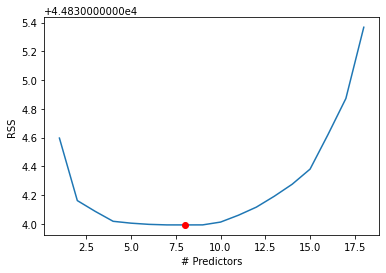

In [7]:
sns.lineplot(x=range(1,19), y=models_test['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_test['RSS'].argmin()+1, models_test['RSS'].min(), 'or')
print(models_test['RSS'].argmin()+1)

### Define function to compute  accuracy and AUC value both of training and testing set with different model

In [8]:
def classification_skl(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred_ts = model.predict(X_test)
    pred_tr = model.predict(X_train)
  
    #Print accuracy
    train_acc = metrics.accuracy_score(pred_tr, y_train)
    train_auc = metrics.roc_auc_score(y_train, pred_tr)
    print ("Training set accuracy : %s" % "{0:.3%}".format(train_acc))
    print ("Training set AUC : %s" % "{0:.3%}".format(train_auc))

    test_acc = metrics.accuracy_score(pred_ts, y_test)
    test_auc = metrics.roc_auc_score(y_test, pred_ts)
    print ("Testing set accuracy : %s" % "{0:.3%}".format(test_acc))
    print ("Testing set AUC : %s" % "{0:.3%}".format(test_auc))



In [9]:
def classification_cu(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred_ts = model.predict(X_test)
    pred_tr = model.predict(X_train)
  
    train_acc = cuacc(y_train.to_numpy(), pred_tr) 
    train_auc = cuauc(y_train.to_numpy(), pred_tr)
    print ("Training set accuracy : %s" % "{0:.3%}".format(train_acc))
    print ("Training set AUC : %s" % "{0:.3%}".format(train_auc))

    test_acc = cuacc(y_test.to_numpy(), pred_ts)
    test_auc = cuauc(y_test.to_numpy(), pred_ts)
    print ("Testing set accuracy : %s" % "{0:.3%}".format(test_acc))
    print ("Testing set AUC : %s" % "{0:.3%}".format(test_auc))


### Logistic Regression

In [10]:
predictor_var = ['term_cat', 'year', 'region', 'emp_length_int', 'installment', 'purpose_cat', 'income_cat', 'home_ownership_cat']

In [17]:
lr_model = LogisticRegression()
classification_skl(lr_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set accuracy : 61.404%
Training set AUC : 58.037%
Testing set accuracy : 61.424%
Testing set AUC : 58.050%


### Decision tree 

In [18]:
dt_model = DecisionTreeClassifier(random_state=0)
classification_skl(dt_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set accuracy : 100.000%
Training set AUC : 100.000%
Testing set accuracy : 60.984%
Testing set AUC : 58.854%


### Random Forest

In [19]:
rf_model = curfc(n_estimators=500, max_depth=16, max_features='auto', random_state=0, n_streams=1)
classification_cu(rf_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set accuracy : 69.336%
Training set AUC : 65.239%
Testing set accuracy : 61.587%
Testing set AUC : 65.539%


### KNN

In [20]:
knn_model = KNeighborsClassifier(n_neighbors=1)
classification_cu(knn_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set accuracy : 100.000%
Training set AUC : 100.000%
Testing set accuracy : 61.089%
Testing set AUC : 58.593%


### Naive Bayes

In [21]:
nb_model = GaussianNB()
classification_cu(nb_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set accuracy : 58.894%
Training set AUC : 65.928%
Testing set accuracy : 59.190%
Testing set AUC : 65.763%


### SVM

In [16]:
# svc_model = SVC(kernel='poly', degree=2, gamma='auto', C=1)
# classification_cu(svc_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)